# Data Explainability and Visualization
In this notebook, we perform exploratory data analysis on the published literature on COVID-19 and try to answer some basic questions such as

1. What is known about transmission, incubation, and environmental stability?
2. What do we know about COVID-19 risk factors?
3. Best medical care?
4. How the COVID-19 spreads and evolves?
5. What are some of the most promising vaccines available (if at all)?

Answering these questions will help clear doubts and answer basic questions with ease.

### Resources
1. https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
2. https://www.youtube.com/watch?v=S6GVXk6kbcs

In [192]:
# handling imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import tqdm, os, re, glob, json
from IPython.display import display
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import random
from gensim import corpora
import pickle
import gensim
import collections
import pyLDAvis.gensim
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
style.use('ggplot')
%matplotlib inline

[nltk_data] Downloading package wordnet to /Users/Janjua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Janjua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
basepath = "/Users/Janjua/Desktop/Projects/Octofying-COVID19-Literature/dataset"
datapath = "CORD-19-research-challenge"

In [9]:
papers = [x for x in glob.glob(os.path.join(basepath, datapath) + "/*/*/*.json")]
print('Total papers found: ', len(papers))
print(papers[:1])

Total papers found:  33375
['/Users/Janjua/Desktop/Projects/Octofying-COVID19-Literature/dataset/CORD-19-research-challenge/custom_license/custom_license/86a998617c077f4fe2ab26214995a3548fbc0fc5.json']


In [18]:
for paper in papers:
    read_paper = json.load(open(paper))
    title = read_paper['metadata']['title']
    try:
        abstract = read_paper['abstract'][0]['text']
    except:
        abstract = "No abstract found"
    paper_text = ""
    for text in read_paper['body_text']:
        paper_text += text['text'] + '\n\n'
    print("="*100)
    print('Title: ', title)
    print("="*100)
    print('Abstract: ', abstract)
    print("="*100)
    print('Paper Contents: ', paper_text)
    print("="*100)
    break

Title:  Middle East Respiratory Syndrome and Severe Acute Respiratory Syndrome
Abstract:  The recent emergence of the Middle East respiratory syndrome (MERS)-CoV, a close relative of the Severe Acute respiratory syndrome (SARS)-CoV, both of which caused a lethal respiratory infection in humans, reinforces the need for further understanding of coronavirus pathogenesis and the host immune response. These viruses have evolved diverse strategies to evade and block host immune responses, facilitating infection and transmission. Pathogenesis following infection with these viruses is characterized by a marked delay in the induction of Type I interferon (IFN I) and, subsequently, by a poor adaptive immune response. Therapies that expedite IFN I induction as well as interventions that antagonize immunoevasive virus proteins are thus promising candidates for immune modulation.
Paper Contents:  While most CoVs cause the common cold in humans, infection with two recently emerged CoVs, SARS-CoV and

In [22]:
def draw_horizontal_lines(times):
    print("="*times)
    
def read_papers():
    papers_contents = []
    for paper in tqdm.tqdm(papers):
        read_paper = json.load(open(paper))
        title = read_paper['metadata']['title']
        try:
            abstract = read_paper['abstract'][0]['text']
        except:
            abstract = "No abstract found"
        paper_text = ""
        for text in read_paper['body_text']:
            paper_text += text['text'] + '\n\n'
        papers_contents.append([title, abstract, paper_text])
    return papers_contents

In [23]:
print("Reading Papers!")
draw_horizontal_lines(100)
papers = read_papers()
print(papers[0])
draw_horizontal_lines(100)

  0%|          | 58/33375 [00:00<00:58, 571.19it/s]

Reading Papers!


100%|██████████| 33375/33375 [01:05<00:00, 508.82it/s]

['Middle East Respiratory Syndrome and Severe Acute Respiratory Syndrome', 'The recent emergence of the Middle East respiratory syndrome (MERS)-CoV, a close relative of the Severe Acute respiratory syndrome (SARS)-CoV, both of which caused a lethal respiratory infection in humans, reinforces the need for further understanding of coronavirus pathogenesis and the host immune response. These viruses have evolved diverse strategies to evade and block host immune responses, facilitating infection and transmission. Pathogenesis following infection with these viruses is characterized by a marked delay in the induction of Type I interferon (IFN I) and, subsequently, by a poor adaptive immune response. Therapies that expedite IFN I induction as well as interventions that antagonize immunoevasive virus proteins are thus promising candidates for immune modulation.', 'While most CoVs cause the common cold in humans, infection with two recently emerged CoVs, SARS-CoV and MERS-CoV, resulted in more 

In [88]:
draw_horizontal_lines(100)
print("Create a dataframe for processing!")
draw_horizontal_lines(100)
df_covid = pd.DataFrame(papers, columns=["title", "abstract", "text"])
display(df_covid.head())

Create a dataframe for processing!


,title,abstract,text
0,Middle East Respiratory Syndrome and Severe Ac...,The recent emergence of the Middle East respir...,While most CoVs cause the common cold in human...
1,"Integrated, Multi-cohort Analysis Identifies C...",Graphical Abstract Highlights d MVS is a commo...,Clinically relevant respiratory viral signatur...
2,Evolutionary Medicine IV. Evolution and Emerge...,No abstract found,The evolutionary history of humans is characte...
3,International aviation emissions to 2025: Can ...,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ..."
4,2 Mechanisms of diarrhoea,No abstract found,Acute infections of the gastrointestinal tract...


In [90]:
def keyword_based_search(keyword, df):
    result = df[df['text'].str.contains(keyword)]
    text_content = result.text.values
    title = result.title.values
    display(result.head())
    relevant_sentences = {'title': [], 'sents': []}
    for sent in tqdm.tqdm(range(len(text_content))):
        sentences = text_content[sent].split('.')
        relevant_sentences['title'].append(title[sent])
        relevant_sentences['sents'].append([s for s in sentences if keyword in s])
    return relevant_sentences

draw_horizontal_lines(100)
print("Getting the subset of DF containing the keyword!")
draw_horizontal_lines(100)
relevant_sentences = keyword_based_search("pregnant women", df_covid)
for i in range(5):
    draw_horizontal_lines(100)
    print("Title: ", relevant_sentences['title'][i])
    print("Sentences: ", relevant_sentences['sents'][i])
    print()

Getting the subset of DF containing the keyword!


,title,abstract,text
136,Medical issues associated with commercial fl i...,Almost 2 billion people travel aboard commerci...,Fitness for air travel is a growing issue beca...
157,Pandemic 2009 influenza A (H1N1) infection amo...,No abstract found,Hajj is the largest annual recurring religious...
201,-NC-ND license (http://creativecommons.org/lic...,Many industrialized countries have implemented...,Vaccination of older adults has been shown to ...
290,Human Metapneumovirus and Other Respiratory Vi...,No abstract found,Human metapneumovirus (HMPV) is a respiratory ...
351,Emerging infectious disease outbreaks: Old les...,No abstract found,The long and prominent role of infectious dise...


100%|██████████| 1126/1126 [00:00<00:00, 4386.68it/s]

Title:  Medical issues associated with commercial fl ights
Sentences:  [' 69 Recommendations need to be in place for pregnant women because the fetus is exposed to the same radiation dose as the mother']

Title:  Pandemic 2009 influenza A (H1N1) infection among 2009 Hajj Pilgrims from Southern Iran: a real-time RT-PCR-based study
Sentences:  [' This finding is understandable in view of the fact that there were no members of high-risk groups such as pregnant women or individuals with chronic health conditions among the pilgrims, and secondly, as previous reports indicate, A(H1N1)pdm09 infection has not been associated with high mortality rates and finally the instructions given to the pilgrims about contact and hand hygiene and respiratory etiquette']

Title:  -NC-ND license (http://creativecommons.org/licenses/by-nc-nd/4.0/)
Sentences:  [' immunization visits at ages 6, 10 and 14 weeks, and 9 months) and pregnant women']

Title:  Human Metapneumovirus and Other Respiratory Viral Infect

## Topic Modelling - Latent Dirichlet allocation
In this section, we perform topic modelling on the corpus (research papers) to retrieve the papers with relevant information.

In [184]:
def get_tokens(text):
    return word_tokenize(text)

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = get_tokens(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

def generate_tokens_for_searched_sentences():
    text_data = []
    title_to_token = {'title': [], 'tokens':[]}
    for ix in range(len(relevant_sentences['title'])):
        full_text = ''.join(x for x in relevant_sentences['sents'][ix])
        title = relevant_sentences['title'][ix]
        tokens = prepare_text_for_lda(full_text)
        if random.random() > 0.7:
            title_to_token['title'].append(title)
            title_to_token['tokens'].append(tokens)
            text_data.append(tokens)
    return text_data, title_to_token
        
def get_corpus(token_data):
    dictionary = corpora.Dictionary(token_data)
    corpus = [dictionary.doc2bow(text) for text in token_data]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    print("Saved dictionary!")
    return corpus, dictionary
    
tokens_data, title_to_token = generate_tokens_for_searched_sentences()
corpus, dictionary = get_corpus(tokens_data)

Saved dictionary!


In [186]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.063*"woman" + 0.055*"pregnant" + 0.018*"vaccine" + 0.013*"include" + 0.012*"infection" + 0.008*"study" + 0.007*"pregnancy" + 0.006*"report" + 0.006*"individual" + 0.006*"infant"')
(1, '0.066*"woman" + 0.063*"pregnant" + 0.021*"infection" + 0.017*"disease" + 0.010*"child" + 0.007*"mortality" + 0.007*"chronic" + 0.006*"vaccination" + 0.006*"study" + 0.006*"include"')
(2, '0.061*"woman" + 0.054*"pregnant" + 0.010*"vaccine" + 0.010*"disease" + 0.008*"increase" + 0.008*"program" + 0.008*"child" + 0.008*"infant" + 0.008*"among" + 0.007*"pregnancy"')
(3, '0.061*"pregnant" + 0.061*"woman" + 0.012*"child" + 0.010*"COVID-19" + 0.009*"anaemia" + 0.009*"study" + 0.009*"infection" + 0.009*"fetus" + 0.008*"pregnancy" + 0.008*"cause"')
(4, '0.026*"woman" + 0.025*"pregnant" + 0.014*"vaccine" + 0.010*"provide" + 0.009*"health" + 0.007*"mother" + 0.007*"communication" + 0.007*"program" + 0.006*"immunization" + 0.005*"child"')
(5, '0.056*"woman" + 0.052*"pregnant" + 0.025*"infection" + 0.011*"vacc

In [187]:
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [190]:
draw_horizontal_lines(100)
print("The papers in this results are: ")
for ix, paper in enumerate(title_to_token['title']):
    if len(paper) > 0:
        print("Nbr: ", ix, " Title: ", paper)
draw_horizontal_lines(100)

The papers in this results are: 
Nbr:  0  Title:  Public Willingness to Take a Vaccine or Drug Under Emergency Use Authorization during the 2009 H1N1 Pandemic
Nbr:  1  Title:  Ribavirin inhibits Zika virus (ZIKV) replication in vitro and suppresses viremia in ZIKV-infected STAT1-deficient mice
Nbr:  2  Title:  Appendix 9-2 Building Emergency Management Plan Building Emergency Procedures Manual
Nbr:  3  Title:  Rates of respiratory virus-associated hospitalization in children aged <5 years in rural northern India
Nbr:  4  Title:  Antiviral Agents
Nbr:  5  Title:  The Sustained Value of an Early Pregnancy Assessment Clinic in the Management of Early Pregnancy Complications: A 10-Year Retrospective Study
Nbr:  6  Title:  Therapeutic Targets for the Treatment of Hepatitis E Virus Infection HHS Public Access
Nbr:  8  Title:  The Lancet Commissions The Tsinghua-Lancet Commission on Healthy Cities in China: unlocking the power of cities for a healthy China Executive summary
Nbr:  11  Title:  

## kNN for Document Similarity
In this section we learn a kNN to retrieve documents which are most similar (contain) the words given in search.
With topic modelling, we have topics against each document, therefore we perform the next step of working out most similar papers.

In [191]:
# revisit the df_covid we created
display(df_covid)

,title,abstract,text
0,Middle East Respiratory Syndrome and Severe Ac...,The recent emergence of the Middle East respir...,While most CoVs cause the common cold in human...
1,"Integrated, Multi-cohort Analysis Identifies C...",Graphical Abstract Highlights d MVS is a commo...,Clinically relevant respiratory viral signatur...
2,Evolutionary Medicine IV. Evolution and Emerge...,No abstract found,The evolutionary history of humans is characte...
3,International aviation emissions to 2025: Can ...,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ..."
4,2 Mechanisms of diarrhoea,No abstract found,Acute infections of the gastrointestinal tract...
...,...,...,...
33370,Lipidome profiles of postnatal day 2 vaginal s...,We hypothesized that postnatal development of ...,Early nutritional environment affects long ter...
33371,"Secondary Syphilis in Cali, Colombia: New Conc...","Venereal syphilis is a multi-stage, sexually t...",Syphilis is a sexually transmitted disease (ST...
33372,Replication and shedding of MERS- CoV in Jamai...,The emergence of Middle East respiratory syndr...,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...
33373,Role of the ERK1/2 Signaling Pathway in the Re...,We have previously shown that the infection of...,Arenaviruses are enveloped RNA viruses contain...


In [263]:
# we compute the most common words occuring in these 33375 documents
def compute_tokens_after_cleaning(sentences):
    wordcount = {}
    for ix in range(len(sentences['title'])):
        full_text = ''.join(x for x in sentences['sents'][ix])
        tokens = prepare_text_for_lda(full_text)
        for word in tokens:
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
    return wordcount
wordcount = compute_tokens_after_cleaning(relevant_sentences)
print(wordcount)

{'Recommendations': 2, 'place': 14, 'pregnant': 3389, 'woman': 3601, 'fetus': 142, 'expose': 54, 'radiation': 3, 'mother': 70, 'finding': 4, 'understandable': 1, 'member': 21, 'high-risk': 57, 'group': 223, 'individual': 148, 'chronic': 152, 'health': 198, 'conditions': 96, 'among': 236, 'pilgrim': 20, 'secondly': 2, 'previous': 36, 'report': 201, 'indicate': 46, 'pdm09': 23, 'infection': 657, 'associate': 115, 'mortality': 170, 'rates': 78, 'finally': 4, 'instructions': 2, 'given': 69, 'contact': 46, 'hygiene': 3, 'respiratory': 134, 'etiquette': 1, 'immunization': 55, 'visit': 30, 'week': 48, 'month': 96, 'incidence': 41, 'characteristic': 24, 'describe': 45, 'Twenty-five': 2, 'infect': 167, 'pregnancy': 323, 'compare': 98, 'contract': 4, 'rhinovirus': 11, 'syncytial': 5, 'virus': 222, 'intervention': 20, 'reduce': 57, 'febrile': 15, 'illness': 132, 'potential': 96, 'decrease': 42, 'adverse': 50, 'birth': 112, 'outcome': 99, 'developing': 37, 'country': 69, 'Illness': 2, 'death': 122

In [248]:
word_counter = collections.Counter(wordcount)            
for word, count in word_counter.most_common(2):
    print(word, ": ", count)

woman :  3601
pregnant :  3389


In [259]:
total_count = len([x for x in word_counter.values() if x > 150]) # take words where occurence more than 50
lst = word_counter.most_common(total_count)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
display(df)

<class 'list'>


,Word,Count
0,woman,3601
1,pregnant,3389
2,infection,657
3,disease,464
4,study,427
5,child,393
6,vaccine,375
7,include,324
8,pregnancy,323
9,patient,322


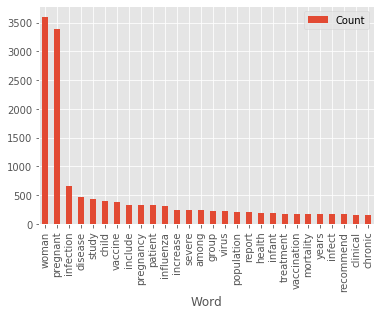

In [236]:
df.plot.bar(x='Word',y='Count')
plt.show()

In [265]:
def tag_documents(wordcount, sentences):
    tagged_docs = []
    word_counter = collections.Counter(wordcount)            
    tag = ' '.join([x[0] for x in word_counter.most_common(2)])
    complete_text_for_topics = ""
    for ix in range(len(sentences['title'])):
        full_text = ''.join(x for x in sentences['sents'][ix])
        complete_text_for_topics += full_text + "\n\n"  
    tagged_docs.append((tag, complete_text_for_topics))
    return tagged_docs

tagged_docs = tag_documents(wordcount, relevant_sentences)
df_tags = pd.DataFrame(tagged_docs, columns = ['Tag', 'Full_Text'])
display(df_tags)

,Tag,Full_Text
0,woman pregnant,69 Recommendations need to be in place for pr...


In [261]:
display(df_covid)

,title,abstract,text
0,Middle East Respiratory Syndrome and Severe Ac...,The recent emergence of the Middle East respir...,While most CoVs cause the common cold in human...
1,"Integrated, Multi-cohort Analysis Identifies C...",Graphical Abstract Highlights d MVS is a commo...,Clinically relevant respiratory viral signatur...
2,Evolutionary Medicine IV. Evolution and Emerge...,No abstract found,The evolutionary history of humans is characte...
3,International aviation emissions to 2025: Can ...,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ..."
4,2 Mechanisms of diarrhoea,No abstract found,Acute infections of the gastrointestinal tract...
...,...,...,...
33370,Lipidome profiles of postnatal day 2 vaginal s...,We hypothesized that postnatal development of ...,Early nutritional environment affects long ter...
33371,"Secondary Syphilis in Cali, Colombia: New Conc...","Venereal syphilis is a multi-stage, sexually t...",Syphilis is a sexually transmitted disease (ST...
33372,Replication and shedding of MERS- CoV in Jamai...,The emergence of Middle East respiratory syndr...,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...
33373,Role of the ERK1/2 Signaling Pathway in the Re...,We have previously shown that the infection of...,Arenaviruses are enveloped RNA viruses contain...


In [294]:
def compute_word_count(sentences):
    wordcount = {}
    tokens = prepare_text_for_lda(sentences)
    for word in tokens:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
    return wordcount

def compute_tag_documents(wordcount):
    word_counter = collections.Counter(wordcount)            
    tag = ' '.join([x[0] for x in word_counter.most_common(2)]) 
    return tag

def generate_tags_for_each_text():
    text_content = df_covid.text.values
    title = df_covid.title.values
    lst_of_tags_per_doc = []
    for sent in tqdm.tqdm(range(len(text_content))):
        wordcount_entire = compute_word_count(text_content[sent])
        tag_for_sent = compute_tag_documents(wordcount_entire)
        lst_of_tags_per_doc.append((tag_for_sent, text_content[sent]))
    return lst_of_tags_per_doc

lst_of_tags_entire = generate_tags_for_each_text()
df_tags_entire_set = pd.DataFrame(lst_of_tags_entire, columns = ['Tag', 'Full_Text'])
display(df_tags_entire_set)

100%|██████████| 33375/33375 [52:22<00:00, 10.62it/s]  


,Tag,Full_Text
0,MERS-CoV response,While most CoVs cause the common cold in human...
1,infection influenza,Clinically relevant respiratory viral signatur...
2,population pathogen,The evolutionary history of humans is characte...
3,emission aviation,"Sixty years ago, civil aviation was an infant ..."
4,toxin diarrhoea,Acute infections of the gastrointestinal tract...
...,...,...
33370,lipid sample,Early nutritional environment affects long ter...
33371,patient syphilis,Syphilis is a sexually transmitted disease (ST...
33372,MERS-CoV Jamaican,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...
33373,U0126 cell,Arenaviruses are enveloped RNA viruses contain...


In [ ]:
# save the df
df_tags_entire_set.to_csv('tagged_texts.csv', index=False, header=True)